# PreTrain

In [1]:
from model.sswae_dev3 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.672
[2] loss: 0.684
[3] loss: 0.372
[4] loss: 0.241
[5] loss: 0.125
[6] loss: 0.057
[7] loss: 0.036
[8] loss: 0.021
[9] loss: 0.016
[10] loss: 0.016
[11] loss: 0.011
[12] loss: 0.007
[13] loss: 0.006
[14] loss: 0.006
[15] loss: 0.009
[16] loss: 0.006
[17] loss: 0.005
[18] loss: 0.003
[19] loss: 0.005
[20] loss: 0.006
[21] loss: 0.005
[22] loss: 0.006
[23] loss: 0.004
[24] loss: 0.002
[25] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 4])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

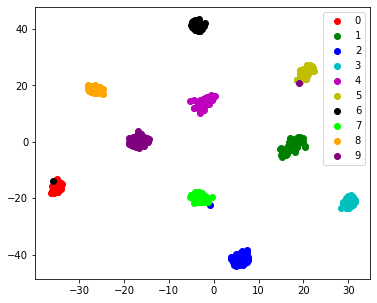

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

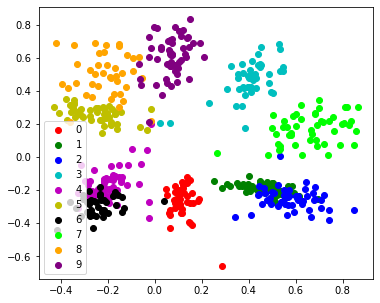

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
# labeled_class = [0,1,2,3,4,5,6,7,8,9]
# train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
# train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
# ys = np.zeros((10, y_dim))
# cs = np.zeros(10)

# for data, condition in train_generator:
#     n = len(data)
#     x = data.to(device)
#     y = condition.to(device)
#     z = embed_condition(embed_data(x))
    
#     labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
#     idxs = labs[idxs].view(n,1).expand(-1, y_dim)
#     cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
#     ys += cc.detach().to('cpu').numpy()
#     cs += counts[labs].detach().to('cpu').numpy()

In [12]:
# w = torch.Tensor(ys.transpose()/cs)
# w

In [13]:
# f1 = nn.Linear(10, y_dim, bias = False)
# f1.weight.data = w
# torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')
f1 = nn.Sequential(embed_data, embed_condition)
torch.save(f1.state_dict(), f'./result/f1_dev3_{y_dim}.pt')

# Train

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev3_1.cfg')

['./config/sswae_dev3_1.cfg']

In [5]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_dev3_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1539] [001/100]  loss: 2.317255e-01  D: 6.925737e-01  D2: 0.000000e+00  D3: 2.894710e-03
test loss: 1.811243e-01  D: 7.021218e-01  D2: 0.000000e+00  D3: 7.840550e-03


[default |INFO|model.py:1539] [002/100]  loss: 1.732336e-01  D: 6.967722e-01  D2: 0.000000e+00  D3: 8.674577e-03
test loss: 1.733177e-01  D: 7.016353e-01  D2: 0.000000e+00  D3: 8.141525e-03


[default |INFO|model.py:1539] [003/100]  loss: 1.570613e-01  D: 6.931946e-01  D2: 0.000000e+00  D3: 8.946920e-03
test loss: 1.454587e-01  D: 6.915453e-01  D2: 0.000000e+00  D3: 9.567664e-03


[default |INFO|model.py:1539] [004/100]  loss: 1.341245e-01  D: 6.931755e-01  D2: 0.000000e+00  D3: 1.052062e-02
test loss: 1.244024e-01  D: 6.975503e-01  D2: 0.000000e+00  D3: 1.411535e-02


[default |INFO|model.py:1539] [005/100]  loss: 1.284225e-01  D: 6.940995e-01  D2: 0.000000e+00  D3: 1.327152e-02
test loss: 1.168442e-01  D: 7.138322e-01  D2: 0.000000e+00  D3: 1.339731e-02


[default |INFO|model.py:1539] [006/100]  loss: 1.322969e-01  D: 6.967107e-01  D2: 0.000000e+00  D3: 1.235869e-02
test loss: 1.155092e-01  D: 7.104431e-01  D2: 0.000000e+00  D3: 1.072280e-02


[default |INFO|model.py:1539] [007/100]  loss: 1.102655e-01  D: 6.927344e-01  D2: 0.000000e+00  D3: 1.177847e-02
test loss: 1.047248e-01  D: 6.870758e-01  D2: 0.000000e+00  D3: 9.193137e-03


[default |INFO|model.py:1539] [008/100]  loss: 1.096397e-01  D: 6.952820e-01  D2: 0.000000e+00  D3: 1.392747e-02
test loss: 1.021234e-01  D: 6.914569e-01  D2: 0.000000e+00  D3: 1.152350e-02


[default |INFO|model.py:1539] [009/100]  loss: 1.211081e-01  D: 6.954297e-01  D2: 0.000000e+00  D3: 1.502988e-02
test loss: 1.127822e-01  D: 7.036877e-01  D2: 0.000000e+00  D3: 1.702417e-02


[default |INFO|model.py:1539] [010/100]  loss: 1.143726e-01  D: 6.944666e-01  D2: 0.000000e+00  D3: 1.674841e-02
test loss: 1.131182e-01  D: 6.945760e-01  D2: 0.000000e+00  D3: 1.813445e-02


[default |INFO|model.py:1539] [011/100]  loss: 1.119962e-01  D: 6.934375e-01  D2: 0.000000e+00  D3: 1.682746e-02
test loss: 1.086578e-01  D: 6.967097e-01  D2: 0.000000e+00  D3: 2.090122e-02


[default |INFO|model.py:1539] [012/100]  loss: 1.039293e-01  D: 6.934431e-01  D2: 0.000000e+00  D3: 1.761244e-02
test loss: 1.003343e-01  D: 6.889552e-01  D2: 0.000000e+00  D3: 1.312992e-02


[default |INFO|model.py:1539] [013/100]  loss: 1.011186e-01  D: 6.956921e-01  D2: 0.000000e+00  D3: 1.803374e-02
test loss: 1.003768e-01  D: 7.191859e-01  D2: 0.000000e+00  D3: 1.807307e-02


[default |INFO|model.py:1539] [014/100]  loss: 1.006913e-01  D: 6.941218e-01  D2: 0.000000e+00  D3: 1.827155e-02
test loss: 1.019840e-01  D: 6.954750e-01  D2: 0.000000e+00  D3: 2.037026e-02


[default |INFO|model.py:1539] [015/100]  loss: 9.794256e-02  D: 6.962904e-01  D2: 0.000000e+00  D3: 1.772246e-02
test loss: 9.534941e-02  D: 6.837617e-01  D2: 0.000000e+00  D3: 1.951945e-02


[default |INFO|model.py:1539] [016/100]  loss: 9.262987e-02  D: 6.944367e-01  D2: 0.000000e+00  D3: 1.838695e-02
test loss: 9.247700e-02  D: 6.970279e-01  D2: 0.000000e+00  D3: 1.911427e-02


[default |INFO|model.py:1539] [017/100]  loss: 9.129772e-02  D: 6.942700e-01  D2: 0.000000e+00  D3: 1.786515e-02
test loss: 8.999762e-02  D: 6.791878e-01  D2: 0.000000e+00  D3: 1.602413e-02


[default |INFO|model.py:1539] [018/100]  loss: 8.956464e-02  D: 6.937529e-01  D2: 0.000000e+00  D3: 1.738854e-02
test loss: 9.112421e-02  D: 7.035116e-01  D2: 0.000000e+00  D3: 1.953222e-02


[default |INFO|model.py:1539] [019/100]  loss: 8.944554e-02  D: 6.952888e-01  D2: 0.000000e+00  D3: 1.724203e-02
test loss: 8.708161e-02  D: 6.861249e-01  D2: 0.000000e+00  D3: 1.720190e-02


[default |INFO|model.py:1539] [020/100]  loss: 8.684071e-02  D: 6.940994e-01  D2: 0.000000e+00  D3: 1.801396e-02
test loss: 8.642665e-02  D: 6.603931e-01  D2: 0.000000e+00  D3: 1.597195e-02


[default |INFO|model.py:1539] [021/100]  loss: 8.721640e-02  D: 6.938421e-01  D2: 0.000000e+00  D3: 1.716211e-02
test loss: 8.334406e-02  D: 6.906262e-01  D2: 0.000000e+00  D3: 1.733028e-02


[default |INFO|model.py:1539] [022/100]  loss: 8.518872e-02  D: 6.941566e-01  D2: 0.000000e+00  D3: 1.736929e-02
test loss: 8.346725e-02  D: 7.021710e-01  D2: 0.000000e+00  D3: 1.926276e-02


[default |INFO|model.py:1539] [023/100]  loss: 8.290737e-02  D: 6.928424e-01  D2: 0.000000e+00  D3: 1.789628e-02
test loss: 8.418249e-02  D: 6.943603e-01  D2: 0.000000e+00  D3: 1.666038e-02


[default |INFO|model.py:1539] [024/100]  loss: 8.297869e-02  D: 6.932215e-01  D2: 0.000000e+00  D3: 1.743892e-02
test loss: 8.498935e-02  D: 6.954021e-01  D2: 0.000000e+00  D3: 1.940453e-02


[default |INFO|model.py:1539] [025/100]  loss: 8.269863e-02  D: 6.945669e-01  D2: 0.000000e+00  D3: 1.722825e-02
test loss: 8.363206e-02  D: 7.005395e-01  D2: 0.000000e+00  D3: 1.945665e-02


[default |INFO|model.py:1539] [026/100]  loss: 8.661492e-02  D: 6.943402e-01  D2: 0.000000e+00  D3: 1.582131e-02
test loss: 8.311510e-02  D: 6.904396e-01  D2: 0.000000e+00  D3: 1.494886e-02


[default |INFO|model.py:1539] [027/100]  loss: 8.605354e-02  D: 6.941454e-01  D2: 0.000000e+00  D3: 1.690724e-02
test loss: 8.213701e-02  D: 6.869060e-01  D2: 0.000000e+00  D3: 1.448154e-02


[default |INFO|model.py:1539] [028/100]  loss: 8.289009e-02  D: 6.950391e-01  D2: 0.000000e+00  D3: 1.687195e-02
test loss: 8.113100e-02  D: 6.618079e-01  D2: 0.000000e+00  D3: 1.607763e-02


[default |INFO|model.py:1539] [029/100]  loss: 7.947717e-02  D: 6.929817e-01  D2: 0.000000e+00  D3: 1.718092e-02
test loss: 8.058849e-02  D: 6.831400e-01  D2: 0.000000e+00  D3: 1.723749e-02


[default |INFO|model.py:1539] [030/100]  loss: 7.910233e-02  D: 6.936515e-01  D2: 0.000000e+00  D3: 1.725022e-02
test loss: 7.822743e-02  D: 6.683931e-01  D2: 0.000000e+00  D3: 1.745987e-02


[default |INFO|model.py:1539] [031/100]  loss: 7.897098e-02  D: 6.932780e-01  D2: 0.000000e+00  D3: 1.694787e-02
test loss: 8.013735e-02  D: 6.963363e-01  D2: 0.000000e+00  D3: 1.914408e-02


[default |INFO|model.py:1539] [032/100]  loss: 7.984165e-02  D: 6.919078e-01  D2: 0.000000e+00  D3: 1.672309e-02
test loss: 7.938123e-02  D: 7.018519e-01  D2: 0.000000e+00  D3: 1.539803e-02


[default |INFO|model.py:1539] [033/100]  loss: 7.946296e-02  D: 6.931167e-01  D2: 0.000000e+00  D3: 1.668017e-02
test loss: 7.779485e-02  D: 6.950060e-01  D2: 0.000000e+00  D3: 1.799988e-02


[default |INFO|model.py:1539] [034/100]  loss: 7.915384e-02  D: 6.940671e-01  D2: 0.000000e+00  D3: 1.690032e-02
test loss: 7.919163e-02  D: 7.180645e-01  D2: 0.000000e+00  D3: 1.795966e-02


[default |INFO|model.py:1539] [035/100]  loss: 7.831794e-02  D: 6.936693e-01  D2: 0.000000e+00  D3: 1.685957e-02
test loss: 7.929942e-02  D: 6.883475e-01  D2: 0.000000e+00  D3: 1.522957e-02


[default |INFO|model.py:1539] [036/100]  loss: 7.784685e-02  D: 6.938942e-01  D2: 0.000000e+00  D3: 1.649776e-02
test loss: 7.640135e-02  D: 7.077095e-01  D2: 0.000000e+00  D3: 1.870369e-02


[default |INFO|model.py:1539] [037/100]  loss: 8.001821e-02  D: 6.939685e-01  D2: 0.000000e+00  D3: 1.608534e-02
test loss: 7.787125e-02  D: 6.986378e-01  D2: 0.000000e+00  D3: 1.818416e-02


[default |INFO|model.py:1539] [038/100]  loss: 7.719540e-02  D: 6.937197e-01  D2: 0.000000e+00  D3: 1.663684e-02
test loss: 7.936877e-02  D: 6.841013e-01  D2: 0.000000e+00  D3: 1.524031e-02


[default |INFO|model.py:1539] [039/100]  loss: 7.640692e-02  D: 6.924870e-01  D2: 0.000000e+00  D3: 1.673034e-02
test loss: 7.680879e-02  D: 6.876695e-01  D2: 0.000000e+00  D3: 1.717350e-02


[default |INFO|model.py:1539] [040/100]  loss: 7.506992e-02  D: 6.938074e-01  D2: 0.000000e+00  D3: 1.695237e-02
test loss: 7.743300e-02  D: 6.847044e-01  D2: 0.000000e+00  D3: 1.614897e-02


[default |INFO|model.py:1539] [041/100]  loss: 7.597362e-02  D: 6.928934e-01  D2: 0.000000e+00  D3: 1.636831e-02
test loss: 7.902883e-02  D: 7.013291e-01  D2: 0.000000e+00  D3: 1.440686e-02


[default |INFO|model.py:1539] [042/100]  loss: 7.560241e-02  D: 6.928392e-01  D2: 0.000000e+00  D3: 1.664072e-02
test loss: 7.733232e-02  D: 6.996147e-01  D2: 0.000000e+00  D3: 1.791256e-02


[default |INFO|model.py:1539] [043/100]  loss: 7.299360e-02  D: 6.939535e-01  D2: 0.000000e+00  D3: 1.675971e-02
test loss: 7.508560e-02  D: 6.837756e-01  D2: 0.000000e+00  D3: 1.638936e-02


[default |INFO|model.py:1539] [044/100]  loss: 7.296208e-02  D: 6.937206e-01  D2: 0.000000e+00  D3: 1.675920e-02
test loss: 7.440467e-02  D: 6.957842e-01  D2: 0.000000e+00  D3: 1.631512e-02


[default |INFO|model.py:1539] [045/100]  loss: 7.272654e-02  D: 6.924520e-01  D2: 0.000000e+00  D3: 1.664115e-02
test loss: 7.386177e-02  D: 6.888856e-01  D2: 0.000000e+00  D3: 1.670879e-02


[default |INFO|model.py:1539] [046/100]  loss: 7.346711e-02  D: 6.942089e-01  D2: 0.000000e+00  D3: 1.646005e-02
test loss: 7.482833e-02  D: 6.994763e-01  D2: 0.000000e+00  D3: 1.634681e-02


[default |INFO|model.py:1539] [047/100]  loss: 7.313428e-02  D: 6.930654e-01  D2: 0.000000e+00  D3: 1.647698e-02
test loss: 7.407741e-02  D: 6.876302e-01  D2: 0.000000e+00  D3: 1.541329e-02


[default |INFO|model.py:1539] [048/100]  loss: 7.192148e-02  D: 6.903598e-01  D2: 0.000000e+00  D3: 1.644154e-02
test loss: 7.232484e-02  D: 6.850142e-01  D2: 0.000000e+00  D3: 1.805043e-02


[default |INFO|model.py:1539] [049/100]  loss: 7.273676e-02  D: 6.943192e-01  D2: 0.000000e+00  D3: 1.641134e-02
test loss: 7.221030e-02  D: 7.055327e-01  D2: 0.000000e+00  D3: 1.705842e-02


[default |INFO|model.py:1539] [050/100]  loss: 7.122093e-02  D: 6.938825e-01  D2: 0.000000e+00  D3: 1.639714e-02
test loss: 7.440210e-02  D: 6.854399e-01  D2: 0.000000e+00  D3: 1.606787e-02


[default |INFO|model.py:1539] [051/100]  loss: 7.178822e-02  D: 6.928967e-01  D2: 0.000000e+00  D3: 1.639592e-02
test loss: 7.460504e-02  D: 7.230291e-01  D2: 0.000000e+00  D3: 1.623713e-02


[default |INFO|model.py:1539] [052/100]  loss: 7.108143e-02  D: 6.934926e-01  D2: 0.000000e+00  D3: 1.637360e-02
test loss: 7.364702e-02  D: 7.052409e-01  D2: 0.000000e+00  D3: 1.658418e-02


[default |INFO|model.py:1539] [053/100]  loss: 7.101139e-02  D: 6.926544e-01  D2: 0.000000e+00  D3: 1.633851e-02
test loss: 7.293380e-02  D: 6.884885e-01  D2: 0.000000e+00  D3: 1.566236e-02


[default |INFO|model.py:1539] [054/100]  loss: 7.170187e-02  D: 6.937642e-01  D2: 0.000000e+00  D3: 1.609020e-02
test loss: 7.551753e-02  D: 6.877861e-01  D2: 0.000000e+00  D3: 1.590239e-02


[default |INFO|model.py:1539] [055/100]  loss: 7.207081e-02  D: 6.944808e-01  D2: 0.000000e+00  D3: 1.614286e-02
test loss: 7.228529e-02  D: 6.946246e-01  D2: 0.000000e+00  D3: 1.519590e-02


[default |INFO|model.py:1539] [056/100]  loss: 7.104544e-02  D: 6.931152e-01  D2: 0.000000e+00  D3: 1.626713e-02
test loss: 7.345483e-02  D: 6.861705e-01  D2: 0.000000e+00  D3: 1.547493e-02


[default |INFO|model.py:1539] [057/100]  loss: 7.101222e-02  D: 6.930741e-01  D2: 0.000000e+00  D3: 1.635548e-02
test loss: 7.474969e-02  D: 6.875283e-01  D2: 0.000000e+00  D3: 1.631563e-02


[default |INFO|model.py:1539] [058/100]  loss: 7.157713e-02  D: 6.944079e-01  D2: 0.000000e+00  D3: 1.619110e-02
test loss: 7.267999e-02  D: 6.847117e-01  D2: 0.000000e+00  D3: 1.626084e-02


[default |INFO|model.py:1539] [059/100]  loss: 7.070946e-02  D: 6.937327e-01  D2: 0.000000e+00  D3: 1.613941e-02
test loss: 7.265195e-02  D: 7.033071e-01  D2: 0.000000e+00  D3: 1.634949e-02


[default |INFO|model.py:1539] [060/100]  loss: 7.015247e-02  D: 6.934657e-01  D2: 0.000000e+00  D3: 1.618628e-02
test loss: 7.389808e-02  D: 6.918004e-01  D2: 0.000000e+00  D3: 1.596128e-02


[default |INFO|model.py:1539] [061/100]  loss: 6.962014e-02  D: 6.930871e-01  D2: 0.000000e+00  D3: 1.627091e-02
test loss: 7.321744e-02  D: 6.959283e-01  D2: 0.000000e+00  D3: 1.608776e-02


[default |INFO|model.py:1539] [062/100]  loss: 6.994978e-02  D: 6.945361e-01  D2: 0.000000e+00  D3: 1.601386e-02
test loss: 7.152647e-02  D: 7.150583e-01  D2: 0.000000e+00  D3: 1.583763e-02


[default |INFO|model.py:1539] [063/100]  loss: 6.899013e-02  D: 6.941970e-01  D2: 0.000000e+00  D3: 1.615589e-02
test loss: 7.110994e-02  D: 6.901680e-01  D2: 0.000000e+00  D3: 1.704819e-02


[default |INFO|model.py:1539] [064/100]  loss: 6.950669e-02  D: 6.936957e-01  D2: 0.000000e+00  D3: 1.609981e-02
test loss: 7.262072e-02  D: 7.002857e-01  D2: 0.000000e+00  D3: 1.649614e-02


[default |INFO|model.py:1539] [065/100]  loss: 6.923367e-02  D: 6.935475e-01  D2: 0.000000e+00  D3: 1.610184e-02
test loss: 7.357023e-02  D: 6.921342e-01  D2: 0.000000e+00  D3: 1.498045e-02


[default |INFO|model.py:1539] [066/100]  loss: 6.918740e-02  D: 6.933237e-01  D2: 0.000000e+00  D3: 1.589737e-02
test loss: 7.180231e-02  D: 6.984431e-01  D2: 0.000000e+00  D3: 1.540538e-02


[default |INFO|model.py:1539] [067/100]  loss: 6.901199e-02  D: 6.932253e-01  D2: 0.000000e+00  D3: 1.589812e-02
test loss: 7.155553e-02  D: 6.870197e-01  D2: 0.000000e+00  D3: 1.593077e-02


[default |INFO|model.py:1539] [068/100]  loss: 6.832056e-02  D: 6.933534e-01  D2: 0.000000e+00  D3: 1.603605e-02
test loss: 7.144525e-02  D: 6.961865e-01  D2: 0.000000e+00  D3: 1.540888e-02


[default |INFO|model.py:1539] [069/100]  loss: 6.883683e-02  D: 6.930530e-01  D2: 0.000000e+00  D3: 1.583382e-02
test loss: 7.181864e-02  D: 6.846797e-01  D2: 0.000000e+00  D3: 1.578699e-02


[default |INFO|model.py:1539] [070/100]  loss: 6.820768e-02  D: 6.938699e-01  D2: 0.000000e+00  D3: 1.594848e-02
test loss: 7.169008e-02  D: 6.917520e-01  D2: 0.000000e+00  D3: 1.570518e-02


[default |INFO|model.py:1539] [071/100]  loss: 6.842587e-02  D: 6.934831e-01  D2: 0.000000e+00  D3: 1.596284e-02
test loss: 7.155433e-02  D: 7.007169e-01  D2: 0.000000e+00  D3: 1.582297e-02


[default |INFO|model.py:1539] [072/100]  loss: 6.811878e-02  D: 6.933998e-01  D2: 0.000000e+00  D3: 1.589151e-02
test loss: 7.229757e-02  D: 6.942936e-01  D2: 0.000000e+00  D3: 1.530450e-02


[default |INFO|model.py:1539] [073/100]  loss: 6.875721e-02  D: 6.935381e-01  D2: 0.000000e+00  D3: 1.570962e-02
test loss: 7.208493e-02  D: 6.854599e-01  D2: 0.000000e+00  D3: 1.634947e-02


[default |INFO|model.py:1539] [074/100]  loss: 6.822139e-02  D: 6.931782e-01  D2: 0.000000e+00  D3: 1.584931e-02
test loss: 7.094475e-02  D: 7.058404e-01  D2: 0.000000e+00  D3: 1.666016e-02


[default |INFO|model.py:1539] [075/100]  loss: 6.774389e-02  D: 6.936147e-01  D2: 0.000000e+00  D3: 1.598819e-02
test loss: 7.105787e-02  D: 6.872514e-01  D2: 0.000000e+00  D3: 1.630592e-02


[default |INFO|model.py:1539] [076/100]  loss: 6.816278e-02  D: 6.929870e-01  D2: 0.000000e+00  D3: 1.582047e-02
test loss: 7.080388e-02  D: 6.931466e-01  D2: 0.000000e+00  D3: 1.687136e-02


[default |INFO|model.py:1539] [077/100]  loss: 6.848516e-02  D: 6.940257e-01  D2: 0.000000e+00  D3: 1.564590e-02
test loss: 7.280400e-02  D: 7.023542e-01  D2: 0.000000e+00  D3: 1.608765e-02


[default |INFO|model.py:1539] [078/100]  loss: 6.763945e-02  D: 6.928013e-01  D2: 0.000000e+00  D3: 1.586603e-02
test loss: 7.202525e-02  D: 6.915707e-01  D2: 0.000000e+00  D3: 1.618466e-02


[default |INFO|model.py:1539] [079/100]  loss: 6.770698e-02  D: 6.931808e-01  D2: 0.000000e+00  D3: 1.577814e-02
test loss: 7.133856e-02  D: 6.881325e-01  D2: 0.000000e+00  D3: 1.691381e-02


[default |INFO|model.py:1539] [080/100]  loss: 6.774920e-02  D: 6.941135e-01  D2: 0.000000e+00  D3: 1.578441e-02
test loss: 7.286057e-02  D: 6.878100e-01  D2: 0.000000e+00  D3: 1.402535e-02


[default |INFO|model.py:1539] [081/100]  loss: 6.811079e-02  D: 6.931752e-01  D2: 0.000000e+00  D3: 1.569352e-02
test loss: 7.233064e-02  D: 6.940329e-01  D2: 0.000000e+00  D3: 1.333961e-02


[default |INFO|model.py:1539] [082/100]  loss: 6.776043e-02  D: 6.933443e-01  D2: 0.000000e+00  D3: 1.556408e-02
test loss: 7.256832e-02  D: 6.988281e-01  D2: 0.000000e+00  D3: 1.652345e-02


[default |INFO|model.py:1539] [083/100]  loss: 6.750731e-02  D: 6.935873e-01  D2: 0.000000e+00  D3: 1.568758e-02
test loss: 7.008967e-02  D: 6.850405e-01  D2: 0.000000e+00  D3: 1.504736e-02


[default |INFO|model.py:1539] [084/100]  loss: 6.743875e-02  D: 6.933548e-01  D2: 0.000000e+00  D3: 1.581083e-02
test loss: 7.267343e-02  D: 6.927578e-01  D2: 0.000000e+00  D3: 1.656721e-02


[default |INFO|model.py:1539] [085/100]  loss: 6.667895e-02  D: 6.937196e-01  D2: 0.000000e+00  D3: 1.567310e-02
test loss: 7.120182e-02  D: 6.931929e-01  D2: 0.000000e+00  D3: 1.579244e-02


[default |INFO|model.py:1539] [086/100]  loss: 6.693968e-02  D: 6.934914e-01  D2: 0.000000e+00  D3: 1.566396e-02
test loss: 7.170586e-02  D: 6.875507e-01  D2: 0.000000e+00  D3: 1.578809e-02


[default |INFO|model.py:1539] [087/100]  loss: 6.739748e-02  D: 6.927652e-01  D2: 0.000000e+00  D3: 1.551322e-02
test loss: 7.056598e-02  D: 6.923182e-01  D2: 0.000000e+00  D3: 1.571837e-02


[default |INFO|model.py:1539] [088/100]  loss: 6.664837e-02  D: 6.933456e-01  D2: 0.000000e+00  D3: 1.566296e-02
test loss: 7.078959e-02  D: 7.009136e-01  D2: 0.000000e+00  D3: 1.544341e-02


[default |INFO|model.py:1539] [089/100]  loss: 6.641634e-02  D: 6.929701e-01  D2: 0.000000e+00  D3: 1.556802e-02
test loss: 7.123704e-02  D: 6.795088e-01  D2: 0.000000e+00  D3: 1.571025e-02


[default |INFO|model.py:1539] [090/100]  loss: 6.671415e-02  D: 6.935949e-01  D2: 0.000000e+00  D3: 1.547362e-02
test loss: 7.051160e-02  D: 6.977180e-01  D2: 0.000000e+00  D3: 1.578515e-02


[default |INFO|model.py:1539] [091/100]  loss: 6.692081e-02  D: 6.929764e-01  D2: 0.000000e+00  D3: 1.547922e-02
test loss: 7.112803e-02  D: 6.804422e-01  D2: 0.000000e+00  D3: 1.595831e-02


[default |INFO|model.py:1539] [092/100]  loss: 6.700643e-02  D: 6.936122e-01  D2: 0.000000e+00  D3: 1.539320e-02
test loss: 7.033084e-02  D: 6.921670e-01  D2: 0.000000e+00  D3: 1.575938e-02


[default |INFO|model.py:1539] [093/100]  loss: 6.693016e-02  D: 6.936091e-01  D2: 0.000000e+00  D3: 1.561190e-02
test loss: 7.135464e-02  D: 6.860753e-01  D2: 0.000000e+00  D3: 1.419542e-02


[default |INFO|model.py:1539] [094/100]  loss: 6.682851e-02  D: 6.934075e-01  D2: 0.000000e+00  D3: 1.543733e-02
test loss: 7.037638e-02  D: 6.901969e-01  D2: 0.000000e+00  D3: 1.487994e-02


[default |INFO|model.py:1539] [095/100]  loss: 6.682772e-02  D: 6.936735e-01  D2: 0.000000e+00  D3: 1.538680e-02
test loss: 7.319097e-02  D: 6.853492e-01  D2: 0.000000e+00  D3: 1.441446e-02


[default |INFO|model.py:1539] [096/100]  loss: 6.682685e-02  D: 6.932839e-01  D2: 0.000000e+00  D3: 1.543551e-02
test loss: 7.090260e-02  D: 6.869634e-01  D2: 0.000000e+00  D3: 1.584912e-02


[default |INFO|model.py:1539] [097/100]  loss: 6.622705e-02  D: 6.935181e-01  D2: 0.000000e+00  D3: 1.539206e-02
test loss: 6.925140e-02  D: 6.848277e-01  D2: 0.000000e+00  D3: 1.551332e-02


[default |INFO|model.py:1539] [098/100]  loss: 6.649576e-02  D: 6.931785e-01  D2: 0.000000e+00  D3: 1.552619e-02
test loss: 7.057452e-02  D: 6.972277e-01  D2: 0.000000e+00  D3: 1.594208e-02


[default |INFO|model.py:1539] [099/100]  loss: 6.657217e-02  D: 6.938250e-01  D2: 0.000000e+00  D3: 1.536534e-02
test loss: 7.071364e-02  D: 7.002274e-01  D2: 0.000000e+00  D3: 1.650735e-02


[default |INFO|model.py:1539] [100/100]  loss: 6.693148e-02  D: 6.939077e-01  D2: 0.000000e+00  D3: 1.535628e-02
test loss: 7.131452e-02  D: 6.928345e-01  D2: 0.000000e+00  D3: 1.458510e-02


[default |INFO|model.py:1609] Training Finished!
[default |INFO|model.py:1610] Elapsed time: 2882.851s


# Test

In [28]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [29]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [31]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

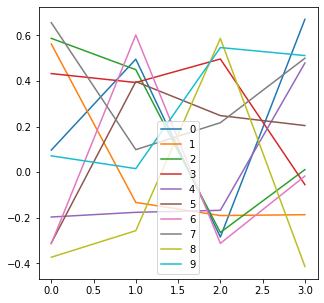

In [32]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

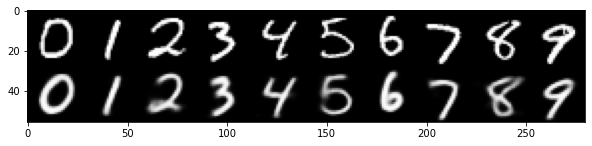

In [33]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [34]:
exn = 5

In [35]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

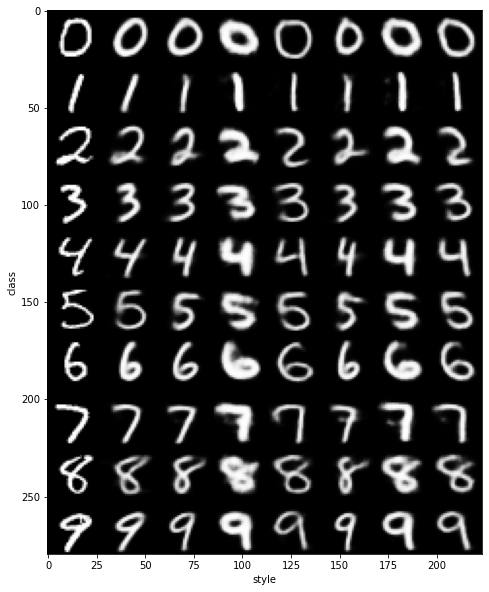

In [36]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [37]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

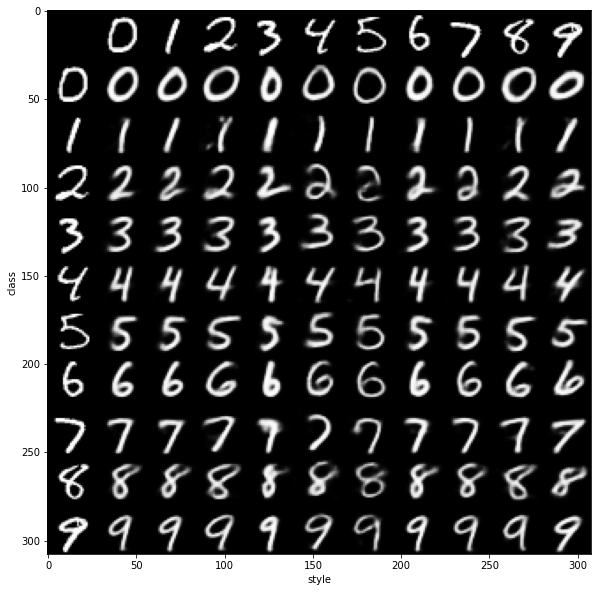

In [38]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()